In [95]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
import keras

In [25]:
# --- Configuration ---
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32 # Keep batch size reasonable for tuning
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

# Adjust EPOCHS for final training, tuner search might use fewer
TUNER_EPOCHS = 15 # Epochs for each trial in the tuner search
FINAL_EPOCHS = 50 # Max epochs for final training after tuning

train_dir = './002/train'
test_dir = './002/test' # Using this as validation set

# --- Create tf.data Datasets (as before) ---
print("Creating Datasets...")
# Load datasets WITHOUT shuffling initially to calculate class weights easily
train_ds_for_weights = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  label_mode='binary',
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE, # Can use batch size here
  shuffle=False # Important: No shuffle for weight calculation
)

# Now create the actual datasets for training/validation with shuffling
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  label_mode='binary',
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  interpolation='nearest',
  batch_size=BATCH_SIZE,
  shuffle=True,
  seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  label_mode='binary',
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  interpolation='nearest',
  batch_size=BATCH_SIZE,
  shuffle=False
)

class_names = train_ds.class_names
print("Class names:", class_names)

# --- Calculate Class Weights for Imbalance ---
print("Calculating class weights...")
labels_iterator = train_ds_for_weights.unbatch().map(lambda x, y: y).as_numpy_iterator()
# Convert labels_iterator to a list or NumPy array
all_labels = np.array(list(labels_iterator))

count_0 = np.sum(all_labels == 0)
count_1 = np.sum(all_labels == 1)
total_samples = len(all_labels)

print(f"Samples - Class 0 ({class_names[0]}): {count_0}")
print(f"Samples - Class 1 ({class_names[1]}): {count_1}")

if count_0 > 0 and count_1 > 0:
    weight_for_0 = (1 / count_0) * (total_samples / 2.0)
    weight_for_1 = (1 / count_1) * (total_samples / 2.0)
    class_weights = {0: weight_for_0, 1: weight_for_1}
    print("Calculated Class Weights:", class_weights)
else:
    print("Warning: One class has zero samples. Cannot calculate class weights.")
    class_weights = None # Handle this case if necessary

# --- Configure Dataset for Performance (as before) ---
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# --- Define Data Augmentation Layers --- <<< ADD THIS BLOCK
# Define the sequential model for augmentation layers
data_augmentation = models.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # Include input_shape here or ensure input tensor has shape
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    # layers.RandomBrightness(0.1), # Optional
    # Add any other augmentation layers you want here
  ],
  name="data_augmentation",
)
print("Data augmentation model defined.")
# --- Define the Model Building Function for KerasTuner ---
def build_model(hp):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')
    # Freeze the base model
    base_model.trainable = False

    # --- Tunable Hyperparameters ---
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4, 5e-5, 1e-5])
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)

    # --- Model Architecture ---
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    # Augmentation - NOW 'data_augmentation' IS DEFINED
    x = data_augmentation(inputs)
    # EfficientNet Preprocessing
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    # Base Model
    x = base_model(x, training=False)
    # Classifier Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x) # Fixed Dense size for simplicity
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp_dropout_rate)(x) # Tunable Dropout
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    # --- Compile with AdamW and More Metrics ---
    optimizer = tf.keras.optimizers.AdamW( # <--- Use tf.keras.optimizers.AdamW
        learning_rate=hp_learning_rate,
        weight_decay=1e-5 # Adjust weight decay if needed
    )
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[
                      'accuracy',
                      tf.keras.metrics.AUC(name='auc'),
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall') # Sensitivity
                  ])
    return model

Creating Datasets...
Found 11879 files belonging to 2 classes.
Found 11879 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Class names: ['Benign', 'Malignant']
Calculating class weights...
Samples - Class 0 (Benign): 6289
Samples - Class 1 (Malignant): 5590
Calculated Class Weights: {0: 0.9444267769120687, 1: 1.0625223613595707}
Data augmentation model defined.


2025-04-07 12:42:36.031162: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
# --- Instantiate the Tuner (RandomSearch) ---
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_auc", direction="max"), # Optimize for validation AUC
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1, # Train each combination once
    directory='keras_tuner_dir', # Directory to store results
    project_name='melanoma_tuning'
)

# --- Run the Hyperparameter Search ---
print("\nStarting hyperparameter search...")
# Use a simple early stopping for the search phase
tuner_early_stopping = EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    train_ds,
    epochs=TUNER_EPOCHS, # Fewer epochs for the search
    validation_data=val_ds,
    class_weight=class_weights, # Apply class weights
    callbacks=[tuner_early_stopping] # Stop trials early if they don't improve
)

# --- Get the Best Hyperparameters ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters found:
Learning Rate: {best_hps.get('learning_rate')}
Dropout Rate: {best_hps.get('dropout_rate')}
""")
# Print other HPs if you tuned them (e.g., dense_units)

Trial 10 Complete [00h 20m 34s]
val_auc: 0.967752993106842

Best val_auc So Far: 0.970221996307373
Total elapsed time: 03h 33m 23s

Best hyperparameters found:
Learning Rate: 0.0001
Dropout Rate: 0.30000000000000004



In [37]:
#kt.engine.hyperparameters.HyperParameters(best_hps.values).values

TypeError: HyperParameters.__init__() takes 1 positional argument but 2 were given

In [27]:
# --- Build and Train the Best Model ---
print("\nBuilding the best model...")
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

print("\nTraining the best model...")
# Define callbacks for final training
final_early_stopping = EarlyStopping(monitor='val_auc', mode='max', patience=10, # Monitor AUC, longer patience
                                     restore_best_weights=True)
# Optionally add ReduceLROnPlateau if needed, but AdamW + good initial LR might be sufficient
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = best_model.fit(
    train_ds,
    epochs=FINAL_EPOCHS, # Train for potentially longer
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[final_early_stopping] # Use final callbacks
)


Building the best model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,180 (16.08 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 4,049,827 (15.45 MB)


Training the best model...
Epoch 1/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 331s 873ms/step - accuracy: 0.7422 - auc: 0.8170 - loss: 0.5521 - precision: 0.7264 - recall: 0.7244 - val_accuracy: 0.8090 - val_auc: 0.9537 - val_loss: 0.4009 - val_precision: 0.9571 - val_recall: 0.6470
Epoch 2/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 585s 2s/step - accuracy: 0.8443 - auc: 0.9213 - loss: 0.3624 - precision: 0.8319 - recall: 0.8374 - val_accuracy: 0.8450 - val_auc: 0.9612 - val_loss: 0.3421 - val_precision: 0.9528 - val_recall: 0.7260
Epoch 3/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 131s 351ms/step - accuracy: 0.8522 - auc: 0.9293 - loss: 0.3445 - precision: 0.8390 - recall: 0.8474 - val_accuracy: 0.8740 - val_auc: 0.9645 - val_loss: 0.3109 - val_precision: 0.9595 - val_recall: 0.7810
Epoch 4/50
372/372 ━━━━━━━━━━━━━━━━━━━━ 106s 284ms/step - accuracy: 0.8585 - auc: 0.9347 - loss: 0.3287 - precision: 0.8466 - recall: 0.8529 - val_accuracy: 0.8830 - val_auc: 0.9656 - val_loss: 0.2897 - val_precision: 0.9506 - val_recall

In [29]:
# --- Evaluate the Final Model ---
print("\nEvaluating the final model on the validation set...")
results = best_model.evaluate(val_ds, verbose=1)

print("\nFinal Model Performance:")
for name, value in zip(best_model.metrics_names, results):
    print(f"{name}: {value:.4f}")


Evaluating the final model on the validation set...
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 243ms/step - accuracy: 0.9475 - auc: 0.5056 - loss: 0.1489 - precision: 0.4535 - recall: 0.4503

Final Model Performance:
loss: 0.2751
compile_metrics: 0.8870


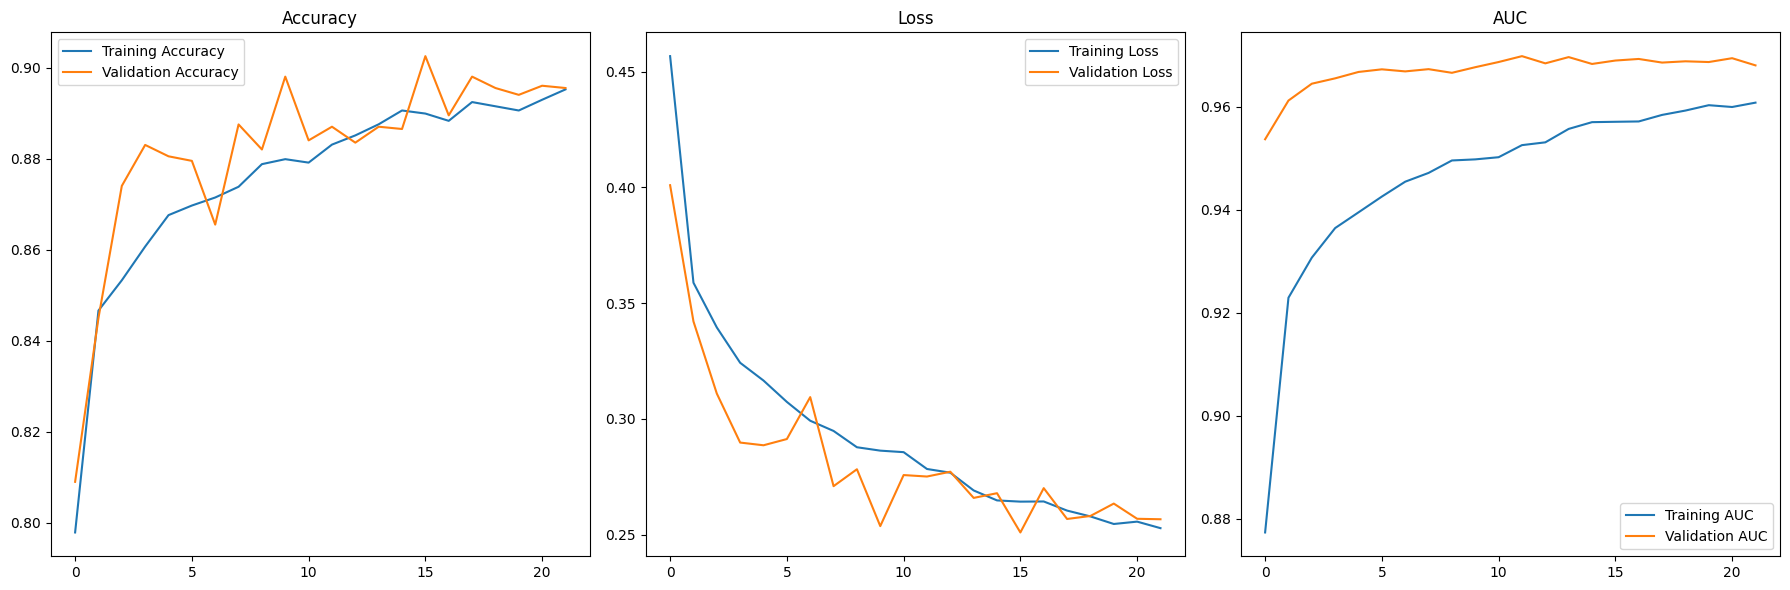

In [30]:

# --- Plot Training History (using final training history) ---
# Extract relevant metrics from history.history (e.g., 'accuracy', 'val_accuracy', 'loss', 'val_loss', 'auc', 'val_auc')
# (Plotting code similar to before, but potentially including AUC plot)
plt.figure(figsize=(18, 6))

# Accuracy Plot
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

# AUC Plot
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
# --- Save the Final Model ---
print("\nSaving the final trained model...")
best_model.save('melanoma_detection_tuned_transfer_model.h5')
print("Model saved successfully.")

# --- Optional: Fine-Tuning ---
# If results are good but could be better, consider unfreezing some layers
# of the base_model and continuing training with a *very* low learning rate.
# This requires careful implementation after the initial training.


Saving the final trained model...
Model saved successfully.


In [41]:
best_val_auc_initial = max(history.history['val_auc'])
print(f"Best Validation AUC achieved during initial head training: {best_val_auc_initial:.4f}")

# --- FINE-TUNING ---
print("\nStarting Fine-Tuning...")

# 1. Unfreeze some layers of the base model
base_model = best_model.layers[2] # Assuming base_model is the 5th layer (Input, Aug, Preproc, ???, Base)
                                   # Double-check with best_model.summary() index might change slightly!
base_model.trainable = True

# Let's keep the first few layers frozen and unfreeze the rest
# Experiment with how many layers to unfreeze. More = more adaptable but higher risk of overfitting.
# Example: Unfreeze layers from block 5 onwards in EfficientNetB0
fine_tune_at_block = 5 # Blocks are typically named 'block1a', 'block2a', etc.
                       # Need to map this concept to layer indices or names

# Find the layer index to fine-tune from (more robust way)
fine_tune_from_layer_name = 'block5a_expand_conv' # Example layer name in EfficientNetB0 block 5
try:
    fine_tune_at_index = [i for i, layer in enumerate(base_model.layers) if layer.name == fine_tune_from_layer_name][0]
    print(f"Will fine-tune from layer '{fine_tune_from_layer_name}' (index {fine_tune_at_index}) onwards.")

    # Freeze all layers before the fine-tune index
    for layer in base_model.layers[:fine_tune_at_index]:
        layer.trainable = False
except IndexError:
    print(f"Warning: Layer '{fine_tune_from_layer_name}' not found. Fine-tuning FULL base model.")
    # Alternatively, adjust the layer name based on `base_model.summary()` output


# 2. Re-compile the model with a VERY LOW learning rate
hp_fine_tune_lr = best_hps.get('learning_rate') / 10 # Start with 1/10th of the best LR found by tuner
# Or set manually: hp_fine_tune_lr = 5e-6  or 1e-5

optimizer_fine_tune = tf.keras.optimizers.AdamW(
    learning_rate=hp_fine_tune_lr,
    weight_decay=1e-5 # Keep same weight decay or adjust if needed
)

best_model.compile(optimizer=optimizer_fine_tune, # Use the new optimizer with low LR
                   loss='binary_crossentropy',
                   metrics=[
                       'accuracy',
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')
                   ])

print("Model re-compiled for fine-tuning.")
best_model.summary() # Notice more trainable parameters now

# 3. Continue training (fine-tuning)
fine_tune_epochs = 25 # Number of epochs for fine-tuning
total_epochs = history.epoch[-1] + 1 + fine_tune_epochs # Continue epoch numbering

# Reset EarlyStopping or use slightly different parameters if desired
fine_tune_early_stopping = EarlyStopping(monitor='val_auc', mode='max', patience=5, # Shorter patience maybe?
                                         restore_best_weights=True, verbose=1)

print(f"Continuing training for {fine_tune_epochs} fine-tuning epochs...")
history_fine = best_model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1, # Start epoch numbering correctly
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[fine_tune_early_stopping] # Use fine-tuning callback(s)
)

# --- Evaluate after Fine-Tuning ---
print("\nEvaluating the final model after fine-tuning...")
results_fine = best_model.evaluate(val_ds, verbose=1)

print("\nFinal Model Performance After Fine-Tuning:")
for name, value in zip(best_model.metrics_names, results_fine):
    print(f"{name}: {value:.4f}")

# --- Save the Fine-Tuned Model ---
print("\nSaving the fine-tuned model...")
best_model.save('melanoma_detection_finetuned_model.h5')
print("Model saved successfully.")

# You can plot the history_fine results similarly to before


Best Validation AUC achieved during initial head training: 0.9699

Starting Fine-Tuning...
Will fine-tune from layer 'block5a_expand_conv' (index 120) onwards.
Model re-compiled for fine-tuning.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,180 (16.08 MB)

 Trainable params: 3,863,241 (14.74 MB)

 Non-trainable params: 350,939 (1.34 MB)

Continuing training for 25 fine-tuning epochs...
Epoch 23/47
372/372 ━━━━━━━━━━━━━━━━━━━━ 225s 581ms/step - accuracy: 0.7476 - auc: 0.8261 - loss: 0.5578 - precision: 0.7131 - recall: 0.7722 - val_accuracy: 0.8550 - val_auc: 0.9348 - val_loss: 0.3534 - val_precision: 0.8998 - val_recall: 0.7990
Epoch 24/47
372/372 ━━━━━━━━━━━━━━━━━━━━ 210s 564ms/step - accuracy: 0.8255 - auc: 0.9093 - loss: 0.4006 - precision: 0.7909 - recall: 0.8534 - val_accuracy: 0.8700 - val_auc: 0.9481 - val_loss: 0.3161 - val_precision: 0.9148 - val_recall: 0.8160
Epoch 25/47
372/372 ━━━━━━━━━━━━━━━━━━━━ 221s 594ms/step - accuracy: 0.8471 - auc: 0.9261 - loss: 0.3615 - precision: 0.8170 - recall: 0.8684 - val_accuracy: 0.8765 - val_auc: 0.9560 - val_loss: 0.2924 - val_precision: 0.9197 - val_recall: 0.8250
Epoch 26/47
372/372 ━━━━━━━━━━━━━━━━━━━━ 204s 549ms/step - accuracy: 0.8615 - auc: 0.9355 - loss: 0.3353 - precision: 0.8319 - recall: 0.8830 - val_accuracy: 0.8840 - val_auc: 0.9603 - val_loss: 0.2721 - val_pr


Final Model Performance After Fine-Tuning:
loss: 0.2199
compile_metrics: 0.9025

Saving the fine-tuned model...
Model saved successfully.


In [42]:
# --- Evaluate after Fine-Tuning ---
print("\nEvaluating the final model after fine-tuning...")
results_fine = best_model.evaluate(val_ds, verbose=1)

print("\nFinal Model Performance After Fine-Tuning:")
for name, value in zip(best_model.metrics_names, results_fine):
    print(f"{name}: {value:.4f}")

# --- Save the Fine-Tuned Model ---
print("\nSaving the fine-tuned model...")
best_model.save('melanoma_detection_finetuned_model.h5')
print("Model saved successfully.")


Evaluating the final model after fine-tuning...
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.9386 - auc: 0.5078 - loss: 0.1381 - precision: 0.4359 - recall: 0.4668



Final Model Performance After Fine-Tuning:
loss: 0.2199
compile_metrics: 0.9025

Saving the fine-tuned model...
Model saved successfully.


In [44]:
print("\nCalculating metrics manually from predictions for verification:")
try:
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, accuracy_score
    import numpy as np

    # Get predictions for the entire validation set
    y_pred_proba = best_model.predict(val_ds)
    y_pred_binary = (y_pred_proba > 0.5).astype(int).flatten() # Apply threshold

    # Get true labels for the entire validation set
    y_true = np.concatenate([y for x, y in val_ds], axis=0).flatten() # Extract all labels

    # Calculate metrics
    manual_accuracy = accuracy_score(y_true, y_pred_binary)
    manual_auc = roc_auc_score(y_true, y_pred_proba) # AUC uses probabilities
    manual_precision = precision_score(y_true, y_pred_binary)
    manual_recall = recall_score(y_true, y_pred_binary)
    cm = confusion_matrix(y_true, y_pred_binary)

    print(f"Manual Accuracy:  {manual_accuracy:.4f}")
    print(f"Manual AUC:       {manual_auc:.4f}")
    print(f"Manual Precision: {manual_precision:.4f}")
    print(f"Manual Recall:    {manual_recall:.4f}")
    print("Confusion Matrix:\n", cm)

except ImportError:
    print("Could not import scikit-learn. Skipping manual metric calculation.")
except Exception as e:
    print(f"Error during manual metric calculation: {e}")


Calculating metrics manually from predictions for verification:
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step
Manual Accuracy:  0.9025
Manual AUC:       0.9768
Manual Precision: 0.9418
Manual Recall:    0.8580
Confusion Matrix:
 [[947  53]
 [142 858]]


2025-04-07 19:53:55.455177: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [53]:
top_conv : tf.keras.layers.Conv2D = best_model.layers[2].layers[-3]
top_conv.


<Conv2D name=top_conv, built=True>

In [47]:
ef_layer = best_model.layers[2] # Assuming base_model is the 5th layer (Input, Aug, Preproc, ???, Base)
ef_layer.layers

[<InputLayer name=input_layer_2, built=True>,
 <Rescaling name=rescaling_2, built=True>,
 <Normalization name=normalization_1, built=True>,
 <Rescaling name=rescaling_3, built=True>,
 <ZeroPadding2D name=stem_conv_pad, built=True>,
 <Conv2D name=stem_conv, built=True>,
 <BatchNormalization name=stem_bn, built=True>,
 <Activation name=stem_activation, built=True>,
 <DepthwiseConv2D name=block1a_dwconv, built=True>,
 <BatchNormalization name=block1a_bn, built=True>,
 <Activation name=block1a_activation, built=True>,
 <GlobalAveragePooling2D name=block1a_se_squeeze, built=True>,
 <Reshape name=block1a_se_reshape, built=True>,
 <Conv2D name=block1a_se_reduce, built=True>,
 <Conv2D name=block1a_se_expand, built=True>,
 <Multiply name=block1a_se_excite, built=True>,
 <Conv2D name=block1a_project_conv, built=True>,
 <BatchNormalization name=block1a_project_bn, built=True>,
 <Conv2D name=block2a_expand_conv, built=True>,
 <BatchNormalization name=block2a_expand_bn, built=True>,
 <Activation na

In [67]:
best_model.layers[2].layers[-3].input

<KerasTensor shape=(None, 7, 7, 320), dtype=float32, sparse=False, ragged=False, name=keras_tensor_480>

In [118]:
import matplotlib as mpl # For colormap
import matplotlib.pyplot as plt # For colormap usage

In [119]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# --- Display GradCAM Overlay --- (Keep as before)
def display_gradcam_overlay(img_pil, heatmap, alpha=0.5):
# ... (display logic) ...
    if heatmap is None: return img_pil
    # ... (rest of display logic) ...
    try:
        img = keras.utils.img_to_array(img_pil); heatmap_uint8 = np.uint8(255 * heatmap)
        jet = mpl.colormaps["jet"]; jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap_uint8]; jet_heatmap_img = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap_resized = jet_heatmap_img.resize((img.shape[1], img.shape[0]))
        jet_heatmap_array = keras.utils.img_to_array(jet_heatmap_resized)
        superimposed_img_array = jet_heatmap_array * alpha + img * (1 - alpha)
        superimposed_img = keras.utils.array_to_img(superimposed_img_array)
        return superimposed_img
    except Exception as e:
        print(f"Error displaying heatmap overlay: {e}"); print(f"Error displaying heatmap overlay: {e}")

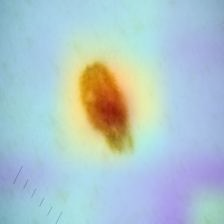

In [127]:
imagen = tf.keras.preprocessing.image.load_img('./002/test/benign/6300.jpg')
arr = tf.keras.preprocessing.image.img_to_array(imagen)
arr = np.expand_dims(arr, axis=0)
heatmap = make_gradcam_heatmap(arr, model, 'top_conv')
image = display_gradcam_overlay(imagen, heatmap, alpha=0.3)
image

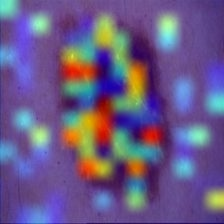

In [111]:
best_model.layers[2].get_layer('block5a_expand_conv').output

<KerasTensor shape=(None, 14, 14, 480), dtype=float32, sparse=False, ragged=False, name=keras_tensor_366>

In [114]:
from tensorflow.keras.applications import EfficientNetB0

best_model.layers[2] 
model = EfficientNetB0(weights='imagenet')
imagen = tf.keras.preprocessing.image.load_img('./002/test/benign/6300.jpg')
arr = tf.keras.preprocessing.image.img_to_array(imagen)
arr = np.expand_dims(arr, axis=0)
heatmap = make_gradcam_heatmap(arr, model, 'block5a_expand_conv')
image = display_gradcam_overlay(imagen, heatmap, alpha=0.3)

21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


<KerasTensor shape=(None, 14, 14, 480), dtype=float32, sparse=False, ragged=False, name=keras_tensor_612>

In [88]:
best_model.get_layer('efficientnetb0').get_layer('top_conv')

<Conv2D name=top_conv, built=True>

In [131]:
best_model.history.history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])

In [134]:
import pandas as pd

In [136]:
df = pd.DataFrame(best_model.history.history)
df.head()
df.to_pickle('model_history.pkl')